# Importando los paquetes que vamos a usar

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from pprint import pprint

# Todas las piezas concretas que usamos de sklearn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

# Funciones comunes a todo el código

## Funciones para evaluar el ajuste

In [2]:
def calculate_roc_auc(true_labels_prob: np.array, predicted_labels_prob: np.array) -> float:
    """
    Calcula el area bajo la curva ROC, dadas las etiquetas verdaderas y las
    etiqeutas predichas por un modelo
    
    Las listas de etiquetas deben ser etiquetas probabilisticas
    """
    return roc_auc_score(true_labels_prob, predicted_labels_prob)
    
def calculaete_accuracy(true_labels: np.array, predicted_labels: np.array) -> float:
    """
    Calcula el accuracy, dadas las etiquetas verdaderas y las
    etiqeutas predichas por un modelo
    """
    return accuracy_score(true_labels, predicted_labels)
    
def evaluate_model(model, x_train: np.ndarray, y_train: np.array, x_test: np.ndarray, y_test: np.array) -> dict:
    """
    Evalua, usando distintas metricas, el modelo que hemos entrenado
    
    Devuelve un diccionario con todas las metricas calculadas con el modelo
    """
    
    # Diccionario en el que vamos a almacenar todas las metricas
    metrics = dict()
    
    # Empezamos usando el modelo para realizar las predicciones+
    # Usamos predicciones probabilisticas pues estas son fundamentales para
    # la competicion
    train_predicted_labels_prob = model.predict_proba(x_train)
    test_predicted_labels_prob = model.predict_proba(x_test)
    
    # Tomamos ahora las etiqeutas sin probabilidad
    train_predicted_labels= model.predict(x_train)
    test_predicted_labels = model.predict(x_test)
           
    # Tomamos las areas bajo la curva ROC
    metrics["train_roc_auc"] = calculate_roc_auc(y_train, train_predicted_labels_prob)
    metrics["test_roc_auc"] = calculate_roc_auc(y_test, test_predicted_labels_prob)
    
    # Tomamos las metricas de accuracy
    metrics["train_acc"] = calculaete_accuracy(y_train, train_predicted_labels)
    metrics["test_acc"] = calculaete_accuracy(y_test, test_predicted_labels)
    
    # Devolvemos las metricas en formato diccionario, que nos va a ser comodo para
    # pasarlas a tablas y para mostrar muchas metricas simultaneamente
    return metrics

## Funciones para hacer la submission

In [3]:
def generate_submission(model, x_test: np.ndarray):
    """
    Dado un conjunto de test, genera las etiquetas que subiremos a la plataforma
    """
    
    prob_labels = model.predict_proba(x_test)
    return prob_labels

## Funciones para manipular `dataframes`

In [4]:
def dataframe_filter_object_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Dado un dataframe, devolvemos una COPIA de este en el que solo
    nos quedamos con las columnas numericas
    
    @param df dataframe que se filtra. No se modifica
    @return new_df dataframe copiado y que se ha filtrado
    """
    
    # No modificamos el dataframe que se pasa como parametro
    new_df = df.copy()
    
    for column, column_type in zip(new_df.columns, new_df.dtypes):
        if column_type == "object":
            new_df = new_df.drop(columns = [column])
                        
    return new_df

# Parámetros globales del Notebook

In [5]:
# Fichero en el que vamos a guardar la prediccion actual
# Es un fichero temporal, porque luego tendremos que nombrarlo y guardarlo en
# el archivo enumerado correspondiente
SUBMISSION_CSV = "./tmp_submission.csv"

# Cargamos los datos del problema

In [6]:
# Cargamos los dos ficheros csv con los datos de entrenamiento
base_path = ".."
df = pd.read_csv("../data/training_set_features.csv")
df_labels = pd.read_csv("../data/training_set_labels.csv")

# Juntamos ambos dataframes en uno solo
df = pd.concat([df, df_labels], axis = 1)
df_labels = None

# Tomamos los datos de test
df_test = pd.read_csv("../data/test_set_features.csv")

## Coloco los nombres de ciertas columnas en variables

Esto para que sea más cómodo trabajar con ciertas columnas principales en el problema

In [7]:
h1n1_vac = "h1n1_vaccine"
seas_vac = "seasonal_vaccine"

# Análisis Exploratorio de datos

In [8]:
df.describe()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,respondent_id,h1n1_vaccine,seasonal_vaccine
count,26707.000000,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,...,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000,26707.000000,26707.000000,26707.000000
mean,13353.000000,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,...,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583,13353.000000,0.212454,0.465608
std,7709.791156,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,...,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173,7709.791156,0.409052,0.498825
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6676.500000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,...,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000,6676.500000,0.000000,0.000000
50%,13353.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,...,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000,13353.000000,0.000000,0.000000
75%,20029.500000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,...,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000,20029.500000,0.000000,1.000000
max,26706.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000,26706.000000,1.000000,1.000000


In [9]:
# TODO -- hacer el conteo de NAN values

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [10]:
df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,1,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,2,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,3,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,4,0,0


In [11]:
df.dtypes

respondent_id                    int64
h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                      

## Mostramos el balanceo de las dos clases que queremos predecir

Vacuna h1n1


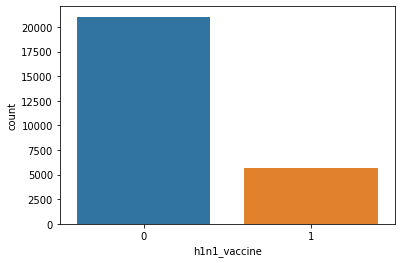

Vacuna seasonal


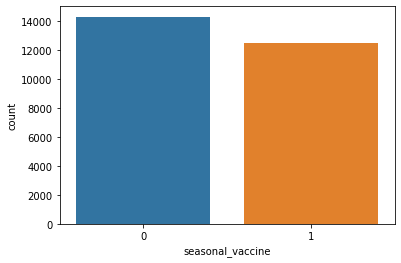

In [12]:
print("Vacuna h1n1")
sns.countplot(data = df, x = h1n1_vac)
plt.show()

print("Vacuna seasonal")
sns.countplot(data = df, x = seas_vac)
plt.show()

## Mostramos el pairplot de todas las variables

In [13]:
# TODO -- implementar

# Pre-procesado de los datos

## Borrado de la columna de identificación

Esta columna no va a ser útil para nuestros modelos de *machine learning*. Por tanto, borramos esta columna del `dataframe`:

In [14]:
# Borramos esta columna para el training
df = df.drop(['respondent_id'], axis=1)
pprint(df.head())

# Borramos esa columna tambien para el test
df_test = df_test.drop(['respondent_id'], axis=1)

   h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
0           1.0             0.0                        0.0   
1           3.0             2.0                        0.0   
2           1.0             1.0                        0.0   
3           1.0             1.0                        0.0   
4           2.0             1.0                        0.0   

   behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
0                   0.0                   0.0                    0.0   
1                   1.0                   0.0                    1.0   
2                   1.0                   0.0                    0.0   
3                   1.0                   0.0                    1.0   
4                   1.0                   0.0                    1.0   

   behavioral_large_gatherings  behavioral_outside_home  \
0                          0.0                      1.0   
1                          0.0                      1.0   
2                

## Combinamos las dos variables de salida en una única

Hacemos esto para, más adelante, poder separar en training / validation estratificando por las dos variables de salida a la vez

In [15]:
combined = "combined"

def combine_two_objective_functions(h1n1, seasonal):
    """
    Funcion que toma los valores de las dos variables objetivo, y las combina en una sola
    """
    
    mapping = dict()
    mapping[0, 0] = 0
    mapping[0, 1] = 1
    mapping[1, 0] = 2
    mapping[1, 1] = 3
    
    return mapping[h1n1, seasonal]

df[combined] = df.apply(lambda row: combine_two_objective_functions(row[h1n1_vac], row[seas_vac]), axis = 1)

## Pasamos todas las variables a variables numéricas

Vamos a usar modelos que solo trabajan con variables numéricas, así que convertimos todas las columnas a numéricas. Para ello, recorremos los tipos de las columnas. Si nos encontramos con una columna de tipo `object`, la convertimos a numérica:

In [16]:
# TODO -- en vez de filtrar, convertir a numerico
df = dataframe_filter_object_columns(df)
df_test = dataframe_filter_object_columns(df_test)
list(set(df.dtypes))

[dtype('int64'), dtype('float64')]

## Separamos el dataframe en training y validation

Separamos en training y validation. validation y no test porque el test es el que nos da la competición. Además, validation porque vamos a usar la informaión sobre este conjunto para ajustar nuestros modelos.

In [17]:
train, validation = train_test_split(df, test_size=0.2, stratify = df[combined])

## Borramos la variable combinada

Ya ha cumplido su propósito: ser la variable de estratificación. Así que la borramos pues no vamos a usar más esta variable

In [18]:
train = train.drop(columns = [combined])
validation = validation.drop(columns = [combined])

## Separamos el dataframe en x, y arrays

In [19]:
all_columns = train.columns
train_columns = list(all_columns)
train_columns.remove(h1n1_vac)
train_columns.remove(seas_vac)

# Separamos segun las columnas del dataframe
x_train, y_train = train[train_columns], train[[h1n1_vac, seas_vac]]
x_validation, y_validation = validation[train_columns], train[[h1n1_vac, seas_vac]]

# Lo convertimos a arrays de numpy
x_train, y_train = np.array(x_train), np.array(y_train)
x_validation, y_validation = np.array(x_validation), np.array(y_validation)
x_test = np.array(df_test)

# Hacemos reshape para que los modelos funcionen bien
#y_train = y_train.reshape(y_train.shape[0] * y_train.shape[1])
#y_validation = y_validation.reshape(y_validation.shape[0] * y_validation.shape[1])

## Imputación de los missing values

Notar que no usamos los datos de salida para realizar la imputación.

In [20]:
print(f"Tamaño previo de entrenamiento: {x_train.shape}")
print(f"Tamaño previo de test: {x_test.shape}")

# Calculamos la imputacion para los valores perdidos
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer.fit(x_train)

# TODO -- usar un imputador mejor
# Aplicamos la imputacion calculada sobre el conjunto de test sobre el resto
# de conjuntos
x_train = pd.DataFrame(imputer.transform(x_train))
x_validation = pd.DataFrame(imputer.transform(x_validation))
x_test = pd.DataFrame(imputer.transform(x_test))

print(f"Tamaño posterior de entrenamiento: {x_train.shape}")
print(f"Tamaño posterior de test: {x_test.shape}")

Tamaño previo de entrenamiento: (21365, 23)
Tamaño previo de test: (26708, 23)
Tamaño posterior de entrenamiento: (21365, 23)
Tamaño posterior de test: (26708, 23)


# Ajuste del modelo

Tenemos un modelo que ajustar según el valor de la variable combinada:

In [21]:
model = MultiOutputClassifier(
    estimator=LogisticRegression(penalty="l2", C=1)
)
model.fit(x_train, y_train)

MultiOutputClassifier(estimator=LogisticRegression(C=1))

# Evaluamos el clasificador en el conjunto de test

In [22]:
#metrics = evaluate_model(model, x_train, y_train, x_validation, y_validation)
#pprint(metrics)

# Entrenamos sobre todo el conjunto de datos 

In [23]:
# TODO -- implementar esto

# Realizamos la propuesta que subimos a DrivenData

## Evaluamos el conjunto de test con nuestro modelo

In [24]:
x_test = np.array(x_test)
submission = generate_submission(model, x_test)

## Guardamos los resultados en un .csv

In [25]:
# Trabajamos con un dataframe para que sea facil guardar los datos en un .csv
submission_df = pd.read_csv("../data/submission_format.csv")

# Nos aseguramos de que los datos esten en el mismo orden
np.testing.assert_array_equal(df_test.index.values, submission_df.index.values)

# Guardamos los resultados en el dataframe
submission_df["h1n1_vaccine"] = submission[0][:, 1]
submission_df["seasonal_vaccine"] = submission[1][:, 1]

# Guardamos el dataframe en un ficher csv
submission_df.to_csv(SUBMISSION_CSV, index=False)

In [26]:
submission_df.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.126387,0.424845
1,26708,0.054528,0.072527
2,26709,0.368434,0.641929
3,26710,0.468506,0.800905
4,26711,0.294304,0.646286
